# **NusaNL**: Nusantara Language
Sunda digital handwriting recognition

## Import Requirement Library

In [ ]:
import os
import time
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from google.colab import drive
from google.colab import files



print('Using TensorFlow Version:', tf.__version__)


Using TensorFlow Version: 2.17.0


## Download and Prepare

### Clone Dataset Aksara Sunda

In [ ]:
!git clone https://github.com/adeiskandarzulkarnaen/dataset-aksarasunda.git

Cloning into 'dataset-aksarasunda'...
remote: Enumerating objects: 8040, done.
remote: Counting objects: 100% (8040/8040), done.
remote: Compressing objects: 100% (8031/8031), done.
remote: Total 8040 (delta 13), reused 8034 (delta 7), pack-reused 0 (from 0)
Receiving objects: 100% (8040/8040), 40.22 MiB | 29.31 MiB/s, done.
Resolving deltas: 100% (13/13), done.


### Visualize Data

In [ ]:
"""
import os
import matplotlib.pyplot as plt
"""


def plot_image_counts(dataset_dir, type):
    """
    Memvisualisasikan jumlah gambar per label dalam direktori dataset
    dan mengatur sumbu y dinamis berdasarkan jumlah gambar terbanyak * 2.

    Parameters:
    dataset_dir (str): Path ke direktori dataset.
    """
    # Mengambil nama-nama label (subfolder) di dalam direktori dataset
    labels = os.listdir(dataset_dir)

    # Inisialisasi dictionary untuk menyimpan jumlah gambar per label
    label_counts = {}

    # Menghitung jumlah gambar per label
    for label in labels:
        label_path = os.path.join(dataset_dir, label)
        if os.path.isdir(label_path):
            num_images = len(os.listdir(label_path))
            label_counts[label] = num_images

    # Mendapatkan jumlah data terbanyak
    max_count = max(label_counts.values())

    # Membuat grafik batang
    plt.figure(figsize=(9, 4))
    plt.bar(label_counts.keys(), label_counts.values(), color='skyblue')
    plt.xlabel('Label')
    plt.ylabel('Banyak Data')
    plt.title(f'Jumlah Data {type}')
    plt.xticks(rotation=90)

    # Mengatur batas sumbu y dinamis (jumlah data terbanyak * 2)
    plt.ylim(0, max_count * 2)

    plt.tight_layout()

    # Menampilkan grafik
    plt.show()

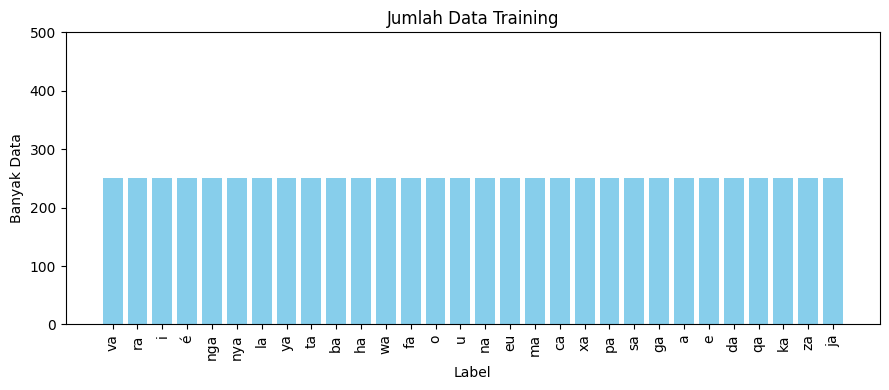

In [ ]:
# Contoh penggunaan fungsi
plot_image_counts('/content/dataset-aksarasunda/dataset/train', 'Training')

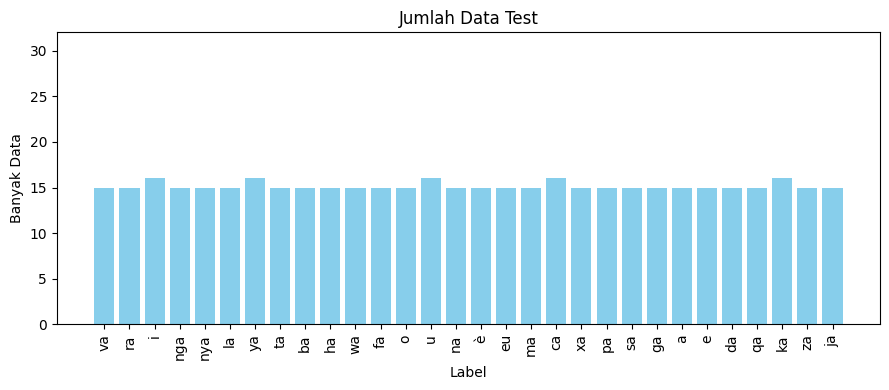

In [ ]:
# Contoh penggunaan fungsi
plot_image_counts('/content/dataset-aksarasunda/dataset/test', 'Test')

## Creating the ImageGenerators for the CNN

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


def train_val_generators(DATASET_DIR):
    """
    This function creates training and validation generators from an image dataset.
    These generators will load images from the directory, normalize them, and split
    the dataset into training and validation subsets.

    Parameters:
    DATASET_DIR (str): Path to the directory containing the image dataset.

    Returns:
    train_generator: Generator for training data.
    validation_generator: Generator for validation data.
    """

    # Create an ImageDataGenerator object for image augmentation and normalization
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,         # Normalize pixel values from 0-255 to 0-1
        validation_split=0.2,   # Split the dataset into 80% for training and 20% for validation
    )


    # Load the training dataset
    train_generator = datagen.flow_from_directory(
        DATASET_DIR,
        target_size=(224, 224),     # Resize images to 224x224 pixels
        batch_size=16,              # Batch size for training
        class_mode='sparse',        # Use sparse class mode (multi-class)
        subset='training',          # Specify the training subset of the dataset
    )

    # Load the validation dataset
    validation_generator = datagen.flow_from_directory(
        DATASET_DIR,
        target_size=(224, 224),     # Resize images to 224x224 pixels
        batch_size=16,              # Batch size for validation
        class_mode='sparse',        # Use sparse class mode (multi-class)
        subset='validation',        # Specify the validation subset of the dataset
    )

    return train_generator, validation_generator

In [ ]:
train_generator, validation_generator = train_val_generators('/content/dataset-aksarasunda/dataset/train')

Found 6000 images belonging to 30 classes.
Found 1500 images belonging to 30 classes.


## Build Model

### Define Callback

In [ ]:
"""
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
"""

# Menambahkan accuracyStop stopping
class AccuracyCallback(Callback):
  # Define the correct function signature for on_epoch_end
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') > 0.99:
      print("\nReached 99% accBuracy so cancelling training!")
      # Stop training once the above condition is met
      self.model.stop_training = True

# Menambahkan accuracyStop stopping
accuracy_callback = AccuracyCallback()

### Create Model

In [ ]:
"""
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

"""


def create_model():
    """
    Creates and compiles a CNN model based on the VGG16 architecture for image classification.

    The model leverages a pre-trained VGG16 base model with added custom top layers for the specific
    classification task. The VGG16 layers are frozen to prevent retraining, allowing the custom layers
    to be trained for the specific dataset.

    Returns:
        model (tf.keras.Model): The compiled Keras model ready for training.
    """

    # Load the VGG16 model with pre-trained weights, excluding the top layers
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Add custom layers on top of the VGG16 base model
    x = base_model.output

    x = layers.GlobalAveragePooling2D()(x)              # Global average pooling to reduce dimensions
    x = layers.Flatten()(x)                             # Flatten the pooled features
    x = layers.Dense(units=512, activation='relu')(x)   # Fully connected layer with ReLU activation
    x = layers.Dropout(0.2)(x)                          # Dropout for regularization to prevent overfitting
    x = layers.Dense(len(train_generator.class_indices), activation='softmax')(x)  # Output layer with softmax activation

    # Create the final model by combining the base model and the custom top layers
    model = Model(inputs=base_model.input, outputs=x)

    # Freeze all layers of the VGG16 base model to prevent them from being trained
    for layer in base_model.layers:
        layer.trainable = False

    # Compile the model with Adam optimizer, sparse categorical crossentropy loss, and accuracy metric
    model.compile(optimizer=Adam(),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model


In [ ]:
model = create_model()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### Show Model summary

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │              

 Total params: 14,992,734 (57.19 MB)

 Trainable params: 278,046 (1.06 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
from tensorflow.keras.utils import plot_model

# pisialization model
model_piz = plot_model(model,
                       to_file='plot_model.png',
                       show_shapes=True,
                       show_layer_names=True,
                       rankdir='TB',
                       expand_nested=True,
                       dpi=150)

## Train Model

In [ ]:
# Train the model, this may take some time.
history = model.fit(train_generator,
                    epochs=10,
                    verbose=1,
                    validation_data=validation_generator,
                    # callbacks=[accuracy_callback])
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


375/375 ━━━━━━━━━━━━━━━━━━━━ 47s 96ms/step - accuracy: 0.3419 - loss: 2.6005 - val_accuracy: 0.8540 - val_loss: 0.8003
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 29s 77ms/step - accuracy: 0.8957 - loss: 0.6124 - val_accuracy: 0.9313 - val_loss: 0.3376
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 30s 79ms/step - accuracy: 0.9634 - loss: 0.2495 - val_accuracy: 0.9627 - val_loss: 0.1936
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 41s 80ms/step - accuracy: 0.9811 - loss: 0.1359 - val_accuracy: 0.9713 - val_loss: 0.1348
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 41s 81ms/step - accuracy: 0.9835 - loss: 0.0963 - val_accuracy: 0.9727 - val_loss: 0.1065
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 30s 80ms/step - accuracy: 0.9898 - loss: 0.0643 - val_accuracy: 0.9653 - val_loss: 0.1214
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 30s 80ms/step - accuracy: 0.9889 - loss: 0.0542 - val_accuracy: 0.9800 - val_loss: 0.0781
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 42s 82ms/step - accuracy: 0.9935 - loss: 0.0385 - val_accurac

## Plot Training History

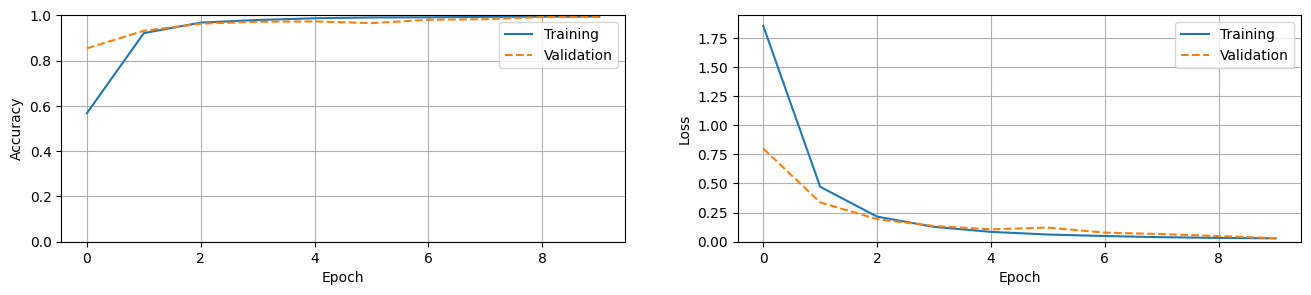

In [ ]:
"""
import matplotlib.pyplot as plt
"""

def plot_metrics(history):
    metrics = ["accuracy", "loss"]
    plt.figure(figsize=(16, 10))

    for n, metric in enumerate(metrics):
        # Change metric name format to uppercase
        name = metric.replace("_", " ").capitalize()

        # Plot training and validation metrics
        plt.subplot(3, 2, n+1)
        plt.plot(history.epoch,
                 history.history[metric],
                 label='Training')
        plt.plot(history.epoch,
                 history.history['val_'+metric],
                 linestyle="--",
                 label='Validation')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        plt.grid(True)

        # Set the y-axis limits for better visualization.
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        else:
            plt.ylim([0, 1])

        plt.legend()

plot_metrics(history)

## Evaluate Model

In [ ]:
# Evaluasi model dengan data validasi
loss, accuracy = model.evaluate(validation_generator, steps=validation_generator.samples // validation_generator.batch_size)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

93/93 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.9953 - loss: 0.0323
Validation Accuracy: 99.40%


### Load Data Testing

In [ ]:
"""
from tensorflow.keras.preprocessing.image import ImageDataGenerator
"""


test_dir = '/content/dataset-aksarasunda/dataset/test'

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)

Found 455 images belonging to 30 classes.


## Evaluate Model With Data Testing ( Confusion Martix )

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 490ms/step - accuracy: 0.8418 - loss: 0.4808
Test Accuracy: 0.8285714387893677
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step


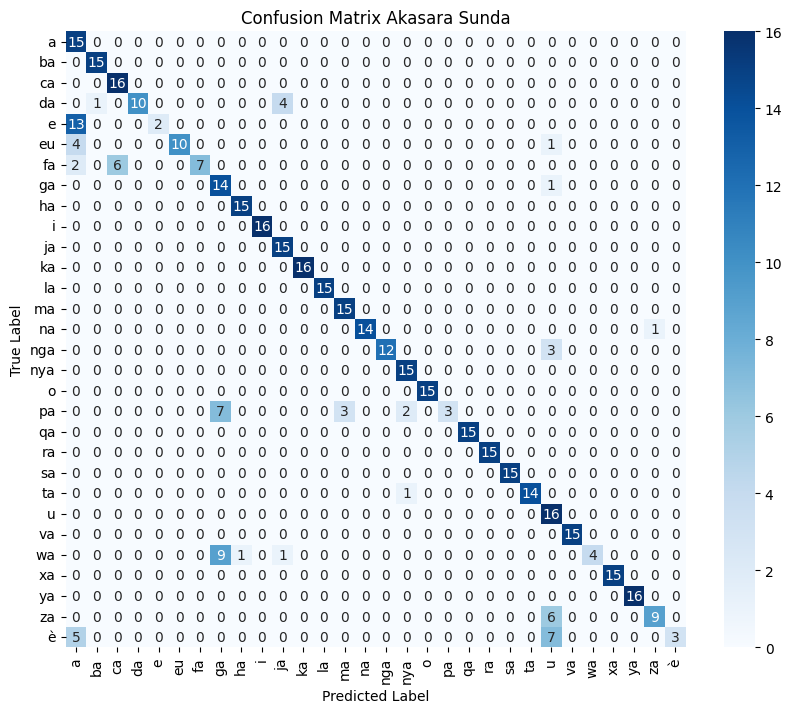

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Evaluasi model dengan test data dan prediksi
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test Accuracy: {test_acc}')

# Prediksi pada data test
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Membuat Confusion Matrix
cm = confusion_matrix(test_generator.classes, y_pred)

# Visualisasi Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix Akasara Sunda')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()



### Create Clasification Report

In [ ]:
# Classification report
print(classification_report(test_generator.classes, y_pred, target_names=test_generator.class_indices.keys()))

              precision    recall  f1-score   support

           a       0.38      1.00      0.56        15
          ba       0.94      1.00      0.97        15
          ca       0.73      1.00      0.84        16
          da       1.00      0.67      0.80        15
           e       1.00      0.13      0.24        15
          eu       1.00      0.67      0.80        15
          fa       1.00      0.47      0.64        15
          ga       0.47      0.93      0.62        15
          ha       0.94      1.00      0.97        15
           i       1.00      1.00      1.00        16
          ja       0.75      1.00      0.86        15
          ka       1.00      1.00      1.00        16
          la       1.00      1.00      1.00        15
          ma       0.83      1.00      0.91        15
          na       1.00      0.93      0.97        15
         nga       1.00      0.80      0.89        15
         nya       0.83      1.00      0.91        15
           o       1.00    

## Save model

### Save To Keras Model

In [ ]:
"""
import time
"""

time_since_epoch = int(time.time())
model.save(f'nusanlsunda_{time_since_epoch}.h5')

### Save to TFLite Model

In [ ]:
# Konversi model ke format TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()


# Simpan model dalam format .tflite
time_since_epoch = int(time.time())
with open(f'modelsunda_{time_since_epoch}.tflite', 'wb') as f:
    f.write(tflite_model)


class_names = list(train_generator.class_indices.keys())

# Simpan ke dalam file label.txt
with open(f'modelsunda_{time_since_epoch}_label.txt', 'w') as f:
    for class_name in class_names:
        f.write(f"{class_name}\n")